# Titanic Survival Analysis

For this analysis, I tested several different classification algorithms and ultimately used a random forest classifier to predict whether or not a passenger on the Titanic survived. The model used the following attributes of the passengers on board, most of which were converted into binary, numeric categorical variables:
- Passenger Class
- Title, which was derived from the originally provided name column
- Sex
- Age, which I converted into a set of 10-year age range columns.
 - Linear regression was used to impute missing ages.
- The number of siblings or spouse a pasenger traveled with, which I converted into a set of binary categorical variables.
- The number of parents or children a pasenger traveled with, which I converted into a set of binary categorical variables.
- The deck a passenger stayed on.
- Ticket fare, which was left as a continuous variable
- Where a passenger embarked from.

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import accuracy_score, r2_score
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from math import isnan

## Previewing and summarizing the data

In [2]:
### read in the training and test datasets and set passengerId as the index in both
train_df = pd.read_csv('train.csv', encoding = 'latin1')
train_df = train_df.set_index('PassengerId')

test_df = pd.read_csv('test.csv', encoding = 'latin1')
test_df = test_df.set_index('PassengerId')

### We're going to make feature selections and missing value imputations that will
### need to apply to both train and test data, so let's combine them into a df that 
### we will split back out into train and test data later
combined_df = train_df.append(test_df)

In [3]:
### preview the data
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
## If we check the data types and value counts for each field, we see that a few
## of the fields are missing values. Age is missing 177 values, cabin is missing nearly 700,
## and Embarked is missing two.
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [6]:
### The test is also missing values for age and cabin, though it has all values
### for embarked. It is, however, missing a value for Fare, which we'll
### replace with the median
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


In [7]:
### repalce missing fares with the median value
combined_df.Fare = combined_df.Fare.fillna(combined_df.Fare.median())

In [8]:
### Check how many unique values are in each field
print('train_df\n', train_df.nunique())
print('-' * 40)
print('test_df\n', test_df.nunique())

train_df
 Survived      2
Pclass        3
Name        891
Sex           2
Age          88
SibSp         7
Parch         7
Ticket      681
Fare        248
Cabin       147
Embarked      3
dtype: int64
----------------------------------------
test_df
 Pclass        3
Name        418
Sex           2
Age          79
SibSp         7
Parch         8
Ticket      363
Fare        169
Cabin        76
Embarked      3
dtype: int64


In [9]:
### Embarked has two missing values in the training data. Sicnce it only has three possible values,
### we'll just impute using the most common value, 'S'
print(train_df.Embarked.value_counts())
combined_df.Embarked = combined_df.Embarked.fillna('S')
combined_df.Embarked = combined_df.Embarked.fillna('S')

S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [10]:
### The deck that a passenger was on can be derived from the cabin field,
### which has a lot of missing values. Before removing cabin, let's see if there are
### any patterns for the records that do have values. (I initially ran my model without the
### deck column derived from cabin, but the accuracy was a bit higher when deck was included)
### Fill the null values with a 'U' for unknown
combined_df.Cabin = combined_df.Cabin.fillna('U')
### The first character in cabin represents the deck, so extract that into a new column
combined_df['deck'] = combined_df['Cabin'].apply(lambda x: x[0:1])
### drop Cabin
combined_df = combined_df.drop('Cabin', axis = 1)

## Exploring the data/feature selection

In [11]:
## Before visualzing the relationships between the variables, I'll reset the training
## dataframe to reflect changes made so far in the combined df.
train_df = combined_df[combined_df.Survived.notnull()]

In [12]:
### Function to make a quick plot showing the proportion of a category in each field that survived
def survival_barplot(field):
    table = train_df.pivot_table(index=field, values='Survived')
    table.plot(kind='bar')
    plt.ylabel('Survival rate')

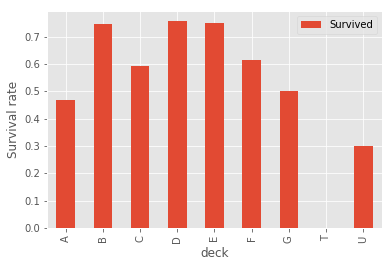

In [13]:
### Passengers in certain decks were more likely to survive than in others, so we'll retain this variable,
### even though it's filled with many 'U' entries
plt.style.use('ggplot')
survival_barplot('deck')

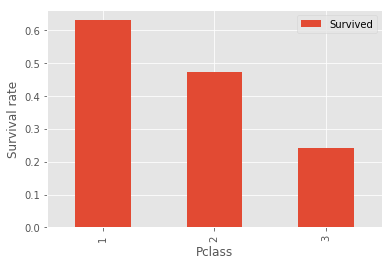

In [14]:
### First class passengers were more likely to survive
survival_barplot('Pclass')

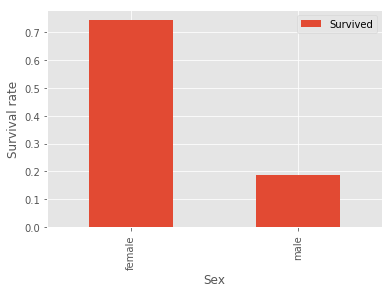

In [15]:
#### Women were much more likely to survive than men
survival_barplot('Sex')

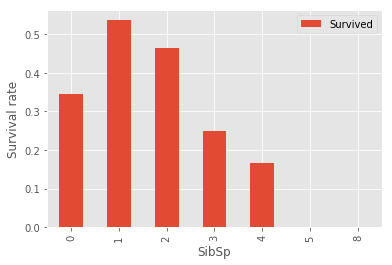

In [16]:
### The number of siblings/spouse that someone was traveling with appears to be relevant, though
### the pattern of survival isn't a linear one. I'll convert this into a categorical variable
survival_barplot('SibSp')

In [17]:
train_df.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [18]:
### Categorize these into three groups: 0, 1-2, 3-4, and 5+
combined_df['SibSp_range'] = pd.cut(combined_df.SibSp,
       bins = [-1, 0, 2, 4, 10],
        labels = ['SipSp_0', 'SipSp_1_2', 'SipSp_3_4', 'SipSp_5+'])

sib_sp_cols = pd.get_dummies(combined_df['SibSp_range'])
combined_df = pd.concat([combined_df, sib_sp_cols], axis = 1).drop(['SibSp', 'SibSp_range'], axis = 1)

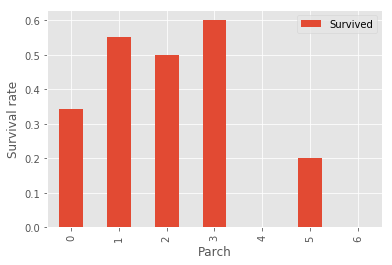

In [19]:
### There's not much of a linear pattern for Parch either, so I'll categorize this field as well
survival_barplot('Parch')

In [20]:
train_df.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [21]:
### let's categorize Parch into three groups: 0, 1-3, and 4+ (Because there were so few
### values for 3, I lumped it into 1-2)
combined_df['Parch_range'] = pd.cut(combined_df.Parch,
       bins = [-1, 0, 3, 10],
        labels = ['Parch_0', 'Parch_1_3', 'Parch_4+'])

parch_cols = pd.get_dummies(combined_df['Parch_range'])
combined_df = pd.concat([combined_df, parch_cols], axis = 1).drop(['Parch', 'Parch_range'], axis = 1)

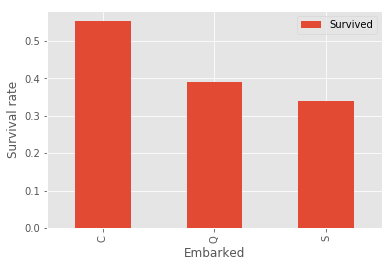

In [22]:
### Where passengers came from also appears to be relevant. We'll use the get_dummies function
### to split these values into distinct columns in a bit
survival_barplot('Embarked')

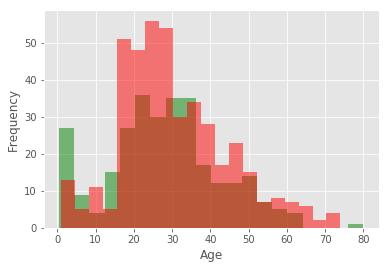

In [23]:
### When we look at how age relates to survival, there doesn't appear to be much of a
### linear relationship, which makes imputing ages a challenge. Being able to use other
### fields to accurately estimate whether a child is younger than 10, for example, would
### probably help a bit with predicting survival. We're going to experiment with imputing ages
### using the mean and via a linear regression and see which leads to a better outcome
age_survived = train_df[train_df.Survived == 1].Age
age_died = train_df[train_df.Survived == 0].Age
age_survived.plot.hist(alpha = .5, color = 'green', bins = 20)
age_died.plot.hist(alpha = .5, color = 'red', bins =20)
plt.xlabel('Age')
plt.show()

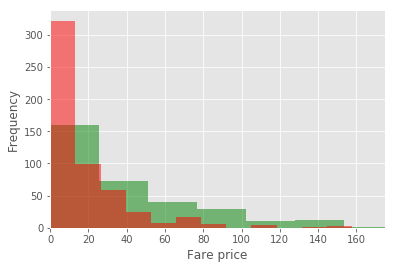

In [24]:
#### With ticket prices, there's a bit more of a pattern. I'll keep this as a continuous variable
fare_survived = train_df[train_df.Survived == 1].Fare
fare_died = train_df[train_df.Survived == 0].Fare
fare_survived.plot.hist(alpha = .5, color = 'green', bins = 20)
fare_died.plot.hist(alpha = .5, color = 'red', bins =20)
### cut off the axis to hide outliers that stretch the chart
plt.xlim(0,175)
plt.xlabel('Fare price')
plt.show()

In [25]:
### an additional variable that might be useful can be parsed from the name field,
### which appears to use consistent titles (Mr., Mrs., Master, etc). Granted, it's certainly
### possible that these titles aren't providing much additional information beyond what's 
### in other fields (titles implying sex, titles implying an age above childhood, a title implying 
### the person may be traveling with a spouse, etc)
def create_title(df):
    name = df.Name
    title = 'N/A'
    if 'Mrs.' in name or 'Lady.' in name or 'Mlle.' in name \
        or 'Mme.' in name or 'Countess.' in name or 'Dona.' in name:
        title = 'Mrs'
    elif 'Mr.' in name or 'Rev.' in name or 'Major.' in name or 'Capt.'\
        in name or 'Col.' in name or 'Don.' in name or 'Sir.' in name:
        title = 'Mr'
    elif 'Miss. ' in name or 'Ms.' in name:
        title = 'Miss'
    elif 'Master.' in name:
        title = 'Master'
    elif 'Dr' in name:
        title = 'Dr'
    ## There's only one guy who doesn't match any above conditions in either dataset
    else:
        title = 'Mr'
    return title

In [26]:
### apply the above function to the train_df in addition to combined_df just so we can visualize it quickly
combined_df['title'] = combined_df.apply(create_title, axis = 1)
train_df['title'] = train_df.apply(create_title, axis = 1)

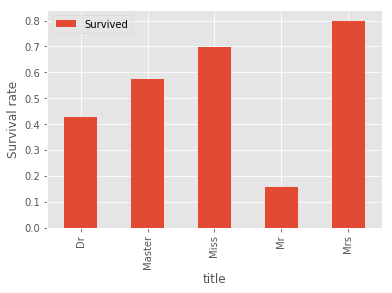

In [27]:
#### Title appears to be a useful field, in part because it makes a pretty clear delineation
### between males with a title of Mr. (very likely to die) and younger boys with "Master," which
### could be useful in cases where age is a missing value
survival_barplot('title')

In [28]:
### Before we can use this data in a model, sex, embarked, class, deck and title all
### need be converted to binary numeric variables.
dummies = pd.get_dummies(combined_df[['Sex', 'Embarked', 'title', 'deck']])
### get_dummies doesn't seem to like column names generated from a numeric value, so
### class is being split in a separate command
class_dummies = pd.get_dummies(combined_df.Pclass).rename(columns = {1: 'Pclass_1',
                                                                 2: 'Pclass_2',
                                                                 3: 'Pclass_3'})

combined_df = pd.concat([combined_df, dummies, class_dummies], axis = 1)

### we can then drop the original variables that have been coded, along with names,
### which we no longer need, and ticket, which we won't use
combined_df = combined_df.drop(['Sex', 'Embarked', 'Pclass', 'title', 'Name', 'Ticket', 'deck'], axis = 1)

In [29]:
#### split the combined df back into training and test data
train_df = combined_df[combined_df.Survived.notnull()]
test_df = combined_df[combined_df.Survived.isnull()].drop('Survived', axis = 1)

## Handling missing ages
- I'm going to test imputing ages using the mean and by making predictions via linear regression, and I'll use logistic regression to test which approach produces a better accuracy score

In [30]:
### initially, I'll try imputing ages with the mean.
train_agemn = train_df.copy(deep=True)
train_agemn['age_mean'] = train_agemn.Age.fillna(train_agemn.Age.mean())

In [31]:
### now divide the age_mean field into buckets
### Divide the ages into 10-year buckets
train_agemn['age_range'] = pd.cut(train_agemn.age_mean,
       bins = [x * 10 for x in range(0,10)],
        labels = ['Age_0_10', 'Age_10_20', 'Age_20_30', 'Age_30_40', 'Age_40_50',
                  'Age_50_60', 'Age_60_70', 'Age_70_80', 'Age_80_90'])

age_cols = pd.get_dummies(train_agemn['age_range'])
train_agemn = pd.concat([train_agemn, age_cols], axis = 1)

In [32]:
### split the data into x/y sets
x = train_agemn.drop(['Survived', 'Age', 'age_mean', 'age_range'], axis = 1)
y = train_agemn[['Survived']].values.ravel()

In [33]:
#### Using logistic regression and calculating a cross-validated mean accruacy score
log_reg_agemn = LogisticRegression()
np.mean(cross_val_score(log_reg_agemn, x, y, cv = 5))

0.8260730331759101

In [34]:
#### Now, I'll try imputing the ages using linear regression. 
train_agelm = train_df.copy(deep=True)

### First, split the data according to whether ages are null -- I'll use the has_ages
## df to create and test a model
has_ages = train_agelm[train_agelm.Age.notnull()]
no_ages = train_agelm[train_agelm.Age.isnull()].drop(['Age'], axis = 1)

In [35]:
### split the has_ages data into x and y sets.
x_ages = has_ages.drop(['Survived', 'Age'], axis = 1)
y_ages = has_ages[['Age']]

In [36]:
lm = LinearRegression()

### Use GridSearchCV to test optimal parameters
param_grid = {'fit_intercept':[True,False],
              'normalize':[True,False],
              'copy_X':[True, False]}

lm_cv = GridSearchCV(lm, param_grid, cv=5)
lm_cv.fit(x_ages, y_ages)
print("Best params : ", lm_cv.best_params_)

Best params :  {'copy_X': True, 'fit_intercept': True, 'normalize': False}


In [37]:
### see how fitting the model with the above parameters performs on a random sample
### so we can plot the results compared to the actual values
x_age_train, x_age_test, y_age_train, y_age_test = train_test_split(x_ages, y_ages,
                                                        test_size = 0.2, random_state = 1)

age_predictions = lm_cv.predict(x_age_test)

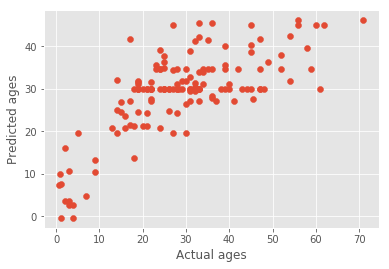

In [38]:
plt.scatter(y_age_test.values, age_predictions, marker = 'o')
plt.xlabel('Actual ages')
plt.ylabel('Predicted ages')
plt.show()

In [39]:
### This might be more helpful to the model than simply imputing the mean,
### since it does appear to get close when it comes to predicting ages of
### some young children, who are much more likley to survive
r2_score(y_age_test, age_predictions)

0.5290863267122428

In [40]:
### use the model to predict ages in the no_ages df
final_age_preds = lm_cv.predict(no_ages.drop('Survived', axis = 1))

In [41]:
### create a new column for ages that were imputed using regression
no_ages['age_lm'] = final_age_preds

### the above plot showed some predicted ages might end up negative. We'll simply change those to 0.1
no_ages.age_lm = no_ages.age_lm.apply(lambda x: 0.1 if x < 0 else x)

In [42]:
## append the data with and without ages back together into a new df
train_agelm = has_ages.append(no_ages).sort_index()

In [43]:
### set the age_lm values in train_df to Age if they're null
train_agelm.age_lm = train_agelm.apply(lambda x: x['Age'] if isnan(x['age_lm']) else x['age_lm'], axis = 1)

In [44]:
### Divide the ages into 10-year buckets using age_lm
train_agelm['age_range'] = pd.cut(train_agelm.age_lm,
       bins = [x * 10 for x in range(0,9)],
        labels = ['Age_0_10', 'Age_10_20', 'Age_20_30', 'Age_30_40', 'Age_40_50',
                  'Age_50_60', 'Age_60_70', 'Age_70_80'])

age_cols = pd.get_dummies(train_agelm['age_range'])
train_agelm = pd.concat([train_agelm, age_cols], axis = 1)

In [45]:
### drop the original age, age_lm and age_range fields, which are no longer needed
train_agelm = train_agelm.drop(['Age', 'age_lm', 'age_range'], axis = 1)

In [46]:
#### Split the data into x/y sets and use cross validation to train and test the model
x = train_agelm.drop(['Survived'], axis = 1)
y = train_agelm[['Survived']].values.ravel()

log_reg_agelm = LogisticRegression()
np.mean(cross_val_score(log_reg_agelm, x, y, cv = 5))

0.8283265721843529

In [47]:
#### The average cross-validated accuracy score was marginally higher when missing
#### ages were imputed using regression than when using the mean, so I'll use that
#### approach for imputing ages moving forward, though this might not make a significant
### difference
final_df = train_agelm.copy(deep = True)

In [48]:
#### Make the same changes to the test data that were just made to the train_agelm data,
### including applying the regression model to the test set
test_no_ages = test_df[test_df.Age.isnull()].drop('Age', axis = 1)
test_has_ages = test_df[test_df.Age.notnull()]

### use the model to impute the ages
test_no_ages['Age'] = lm_cv.predict(test_no_ages)

### append the data back togethr
test_df = test_no_ages.append(test_has_ages).sort_index()

In [49]:
#### Again, for the test df, divide the ages into 10-year buckets
test_df['age_range'] = pd.cut(test_df.Age,
       bins = [x * 10 for x in range(0,9)],
        labels = ['Age_0_10', 'Age_10_20', 'Age_20_30', 'Age_30_40', 'Age_40_50',
                  'Age_50_60', 'Age_60_70', 'Age_70_80'])

age_cols = pd.get_dummies(test_df['age_range'])
test_df = pd.concat([test_df, age_cols], axis = 1)

### then drop the age and age_range columns
test_df = test_df.drop(['Age', 'age_range'], axis = 1)

In [50]:
#### make sure the test and train dfs have the same columns, with the exception of Survived
set(final_df) ^ set(test_df)

{'Survived'}

## Testing different models
### Now that paramaters are finalized, I'll test the following models:
- Logistic Regression
- Linear SVC
- K-means clustering
- Random Forest
- Decision Tree

In [51]:
### split the final df into x/y train/test data
x = final_df.drop(['Survived'], axis = 1)
y = final_df[['Survived']].values.ravel()

In [52]:
### Function using gridsearchcv for cross-validation and parameter tuning. Returns
### model with parameters that produced the highest accuracy score
def score_model(model, param_grid):

    model_cv = GridSearchCV(model, param_grid, cv = 5, scoring = 'accuracy')
    model_cv.fit(x, y)
    print("Best score:", model_cv.best_score_)
    print("Params chosen: ",(model_cv.best_params_))
    return model_cv

In [53]:
## Logistic Regression
logreg = LogisticRegression()
c = np.logspace(-5, 8, 15)
param_grid = {'C': c,
             'penalty': ['l1', 'l2'],
             'fit_intercept': [True, False],
             }
logreg_final_model = score_model(logreg, param_grid)

Best score: 0.8294051627384961
Params chosen:  {'C': 0.4393970560760795, 'fit_intercept': True, 'penalty': 'l2'}


In [54]:
## Linear SVC Regression
svc = LinearSVC()
c = np.logspace(-5, 8, 15)
param_grid = {
            'C': c,
            'fit_intercept': [True, False]
            }
svc_final_model = score_model(svc, param_grid)

Best score: 0.8237934904601572
Params chosen:  {'C': 0.05179474679231213, 'fit_intercept': False}


In [55]:
## K-means
km = KNeighborsClassifier()
param_grid = {
            'n_neighbors': np.arange(1, 50),
            'weights': ['uniform', 'distance']
}
km_final_model = score_model(km, param_grid)

Best score: 0.7878787878787878
Params chosen:  {'n_neighbors': 7, 'weights': 'uniform'}


In [56]:
### Decision Tree
dt = DecisionTreeClassifier()
param_grid = {
            'criterion' :['gini', 'entropy'],
            'max_depth': np.arange(1,20),
            'max_leaf_nodes': [None, 5, 10, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 5, 10]
            }
df_final_model = score_model(dt, param_grid)

Best score: 0.8327721661054994
Params chosen:  {'criterion': 'gini', 'max_depth': 4, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 5}


In [57]:
### random forest. Attempting to tune additional parameters didn't do much to improve accuracy
### and significantly increased processing time (this is quite slow as is), so I've limited
### parameters to what's included below
rm = RandomForestClassifier()
param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(1,10),
    'criterion' :['gini', 'entropy']
}
rm_final_model = score_model(rm, param_grid)

Best score: 0.8338945005611672
Params chosen:  {'criterion': 'gini', 'max_depth': 7, 'max_features': 'auto', 'n_estimators': 200}


In [58]:
### By the slimmest of nargins, a random forest classifier produced the best
### cross-validated accuracy score, so we'll use it to make predictions on test_df 
final_preds = rm_final_model.predict(test_df)
test_df['Survived'] = final_preds

In [59]:
### kaggle requires predictions to be integers, not floats
test_df.Survived = test_df.Survived.astype('int')

In [61]:
### write the final predictions to a file
test_df[['Survived']].to_csv('submission.csv')